# Data extraction

The following code, extracts, loads, subsets and plots data used in the analysis and to prepare figures for the paper. These include:

 -  data on global production of buckwhat, available from [EarthStat](http://www.earthstat.org/)
 -  outline of the continents and the shaded relief map combined with custom elevation colors from [Natural Earth](https://www.naturalearthdata.com/)
 -  administrative division of China available from [DIVA-GIS](https://www.diva-gis.org/gdata)
 -  data on climatic conditions for the past 120 000 years made available by [Beyer et al. 2019](https://doi.org/10.1038/S41597-020-0552-1) ([figshare repository](https://figshare.com/articles/dataset/LateQuaternary_Environment_nc/12293345))
 -  pollen recrods available from ([Cao et al. 2013](https://doi.org/10.1016/j.revpalbo.2013.02.003)), and obtained from the authors (original file not provided here only the subset with *Fagopyrum* records)
 -  dataset with the locations of fagopyrum macro and micro remains from China, based on [Hunt et al. 2018](https://doi.org/10.1007/s00334-017-0649-4), and available in the project's repository (original data sources for individual sites are provided in [ESM 3](../data/ESM_3.pdf)).

In [ ]:
### Load libraries:
library(here) # setting paths
library(raster) # for spatial data
library(rgdal) # for spatial data
library("rioja") # pollen plots
library(maptools) # making maps with plotRGB
library(prettymapr) # for north arrow
library(tmap) # map visualisations
library(stringr) # wraps labels on the maps
library(ncdf4) # loading climate data

In [2]:
### Load utility functions that will be used in data processing and plots:
source(here("R","extractRastersFromNetCDF.r"))
source(here("R","theme_tmaps.R"))

In [3]:
### Define urls from which to download data and paths to their location in the repository:

# Production data:
prod_url <- "https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/buckwheat_HarvAreaYield_Geotiff.zip"
# Also define the name of the folder with the production data, taken from the path
prod_fname<-here("raw_data","buckwheat_HarvAreaYield_Geotiff")

# Outline of the continents:
cont_url<-"https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/physical/ne_50m_land.zip"
# Also define the name of the folder with continents, taken from the path
cont_fname<-here("raw_data","ne_50m_land")

# Administrative division of China:
china_url<-"http://biogeo.ucdavis.edu/data/diva/adm/CHN_adm.zip"
# Define the directory to which the files will be extracted
china_fname <- here("raw_data","CHN_adm")

# Environmental variables:
env_url <- "https://ndownloader.figshare.com/articles/12293345/versions/3"
# Define the directory to which the files will be extracted
env_fname <- here("raw_data","12293345")

# Shaded relief map of the world:

ne_url <- "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/HYP_HR_SR_W_DR.zip"
ne_fname <-here("raw_data","HYP_HR_SR_W_DR")

# Pollen data from Cao et al 2013:
path2pollen<-here("raw_data","FossilPollenDatabasePercentageAsian.csv")

# Fagopyrum locations:

path2locations<-here("data","ESM_2.csv")

# Path to raw data folder
path2raw_data<- here("raw_data")

In [4]:
### Define the output paths:

# Subsets of production data
path2clipped_china<-here("data","buckwheat_production","clipped")
path2masked_china<-here("data","buckwheat_production","masked")

# Plots of production in the world and in China
path2world_production <- here("outputs","ESM_4.tiff")
path2china_production <- here("outputs","ESM_5.tiff")

# Table with full names and short names of environmental variables:

path2env_table<-here("outputs","01_01_Predictor_variables.csv")

# Past environmental layers:

path2past_env<-here("data","environmental","past")
path2present_env<-here("data","environmental","present")

# Pollen diagrams

path2pollen_diag<-here("outputs","ESM_1.pdf")

# Map of site locations (figure 1)

path2locations_map<-here("outputs","Fig1.jpeg")

In [ ]:
# Create directory to downlaod raw data into:
dir.create(path2raw_data)

## Present distribution of buckwheat

### Extract global production

Data on the present global production of buckwhat is available from [EarthStat](http://www.earthstat.org/) and contains information on the volume of production, cultivated area and yield, as well as data quality. In the model it will be used as a proxy for the suitabiliy of environment for buckwheat cultivation (response variable). The following code downloads the data from EarthStat and extracts the individual files from the archive. Then it also downloads and loads the files with the outline of the continents from [NaturalEarth](https://www.naturalearthdata.com/downloads/50m-physical-vectors/) to serve as a background for data visualisation and plots the visualisation.

In [6]:
### Download and extract the production data

# Download the zipped folder 
download.file(prod_url,paste(prod_fname,".zip",sep=""), mode = "wb")
# Unzip the folder and get the names of its contents:
prod_files <- unzip(paste(prod_fname,".zip",sep=""),exdir=path2raw_data)
# Remove the zipped folder
file.remove(paste(prod_fname,".zip",sep=""))

[1] TRUE

In [7]:
### Download the shapefile of the continents as well:

# Download the zipped folder 
download.file(cont_url,paste(cont_fname,".zip",sep=""), mode = "wb")
# Unzip the folder and get the names of its contents:
files <- unzip(paste(cont_fname,".zip",sep=""),exdir=cont_fname)
# Remove the zipped folder
file.remove(paste(cont_fname,".zip",sep=""))

[1] TRUE

In [8]:
### Load data into workspace:

# List all layers related to buckwheat production
prod_layers<-list.files(path=prod_fname,pattern='tif$',full.names=TRUE)
# Put all the layers into a raster stack
prd<-stack(prod_layers)
# Load the shapefile with the outline of the continents
continents <- readOGR(dsn = cont_fname, layer = sub('.*/', '', cont_fname))

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\BuckwheatNicheModelling\raw_data\ne_50m_land", layer: "ne_50m_land"
with 1420 features
It has 3 fields
Integer64 fields read as strings:  scalerank 


In [9]:
### Prepare the names and appropriate aesthetics for the plots of ESM 4 and 5:

# Look at the existing names of the layers in the raster stack
names(prd)
# Create a list of more informative names
prod_names <- c("Data quality: harvested area","Data quality: yield","Harvested area: fractional","Harvested area: hectares",
            "Production in tons","Yield (tons per hectare)")
# Prepare the key from the census level of data quality layers (available from metadata pdf in a downloaded folder) 
census_level <-c("missing census data","country level census data","interpolated from within 2° lat/lon","state level census data","county level census data")

#Make a color palette for visualisation
pal <- colorRampPalette(c("lightyellow","orange","orange3","saddlebrown"))

# Set NA's to the cells that represent the seas in the data quality layers:
prd[[1]][is.na(prd[[3]])]<-NA
prd[[2]][is.na(prd[[3]])]<-NA

[1] "buckwheat_DataQuality_HarvestedArea" "buckwheat_DataQuality_Yield"        
[3] "buckwheat_HarvestedAreaFraction"     "buckwheat_HarvestedAreaHectares"    
[5] "buckwheat_Production"                "buckwheat_YieldPerHectare"

stars object downsampled to 1414 by 707 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 1414 by 707 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 1414 by 707 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 1414 by 707 cells. See tm_shape manual (argument raster.downsample)



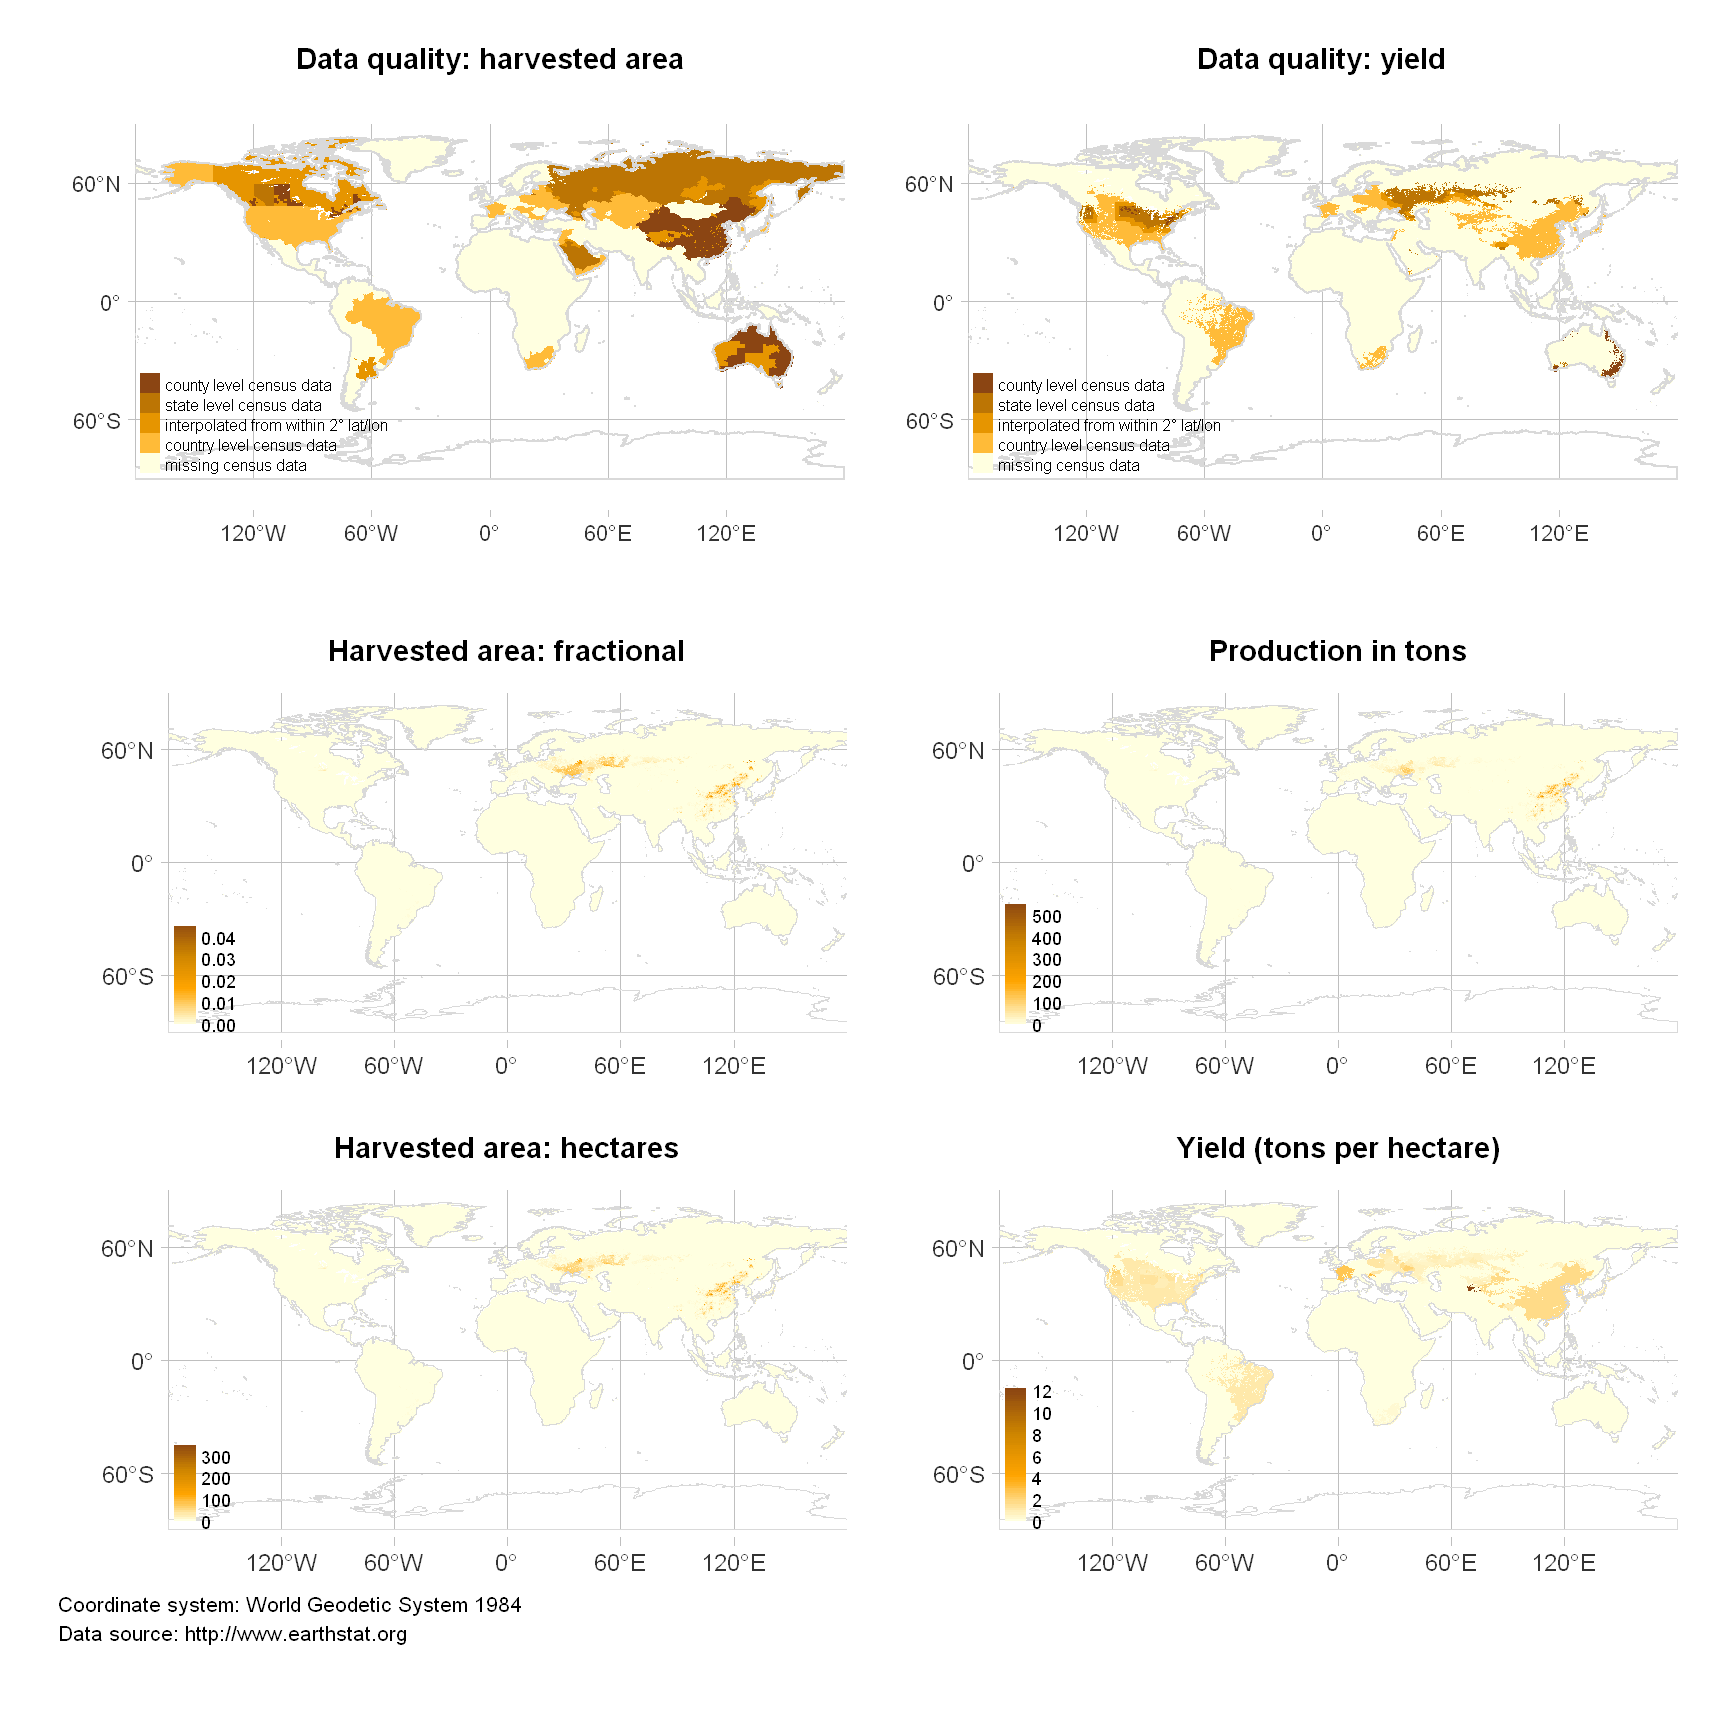

In [78]:
options(repr.plot.width=6.85,repr.plot.height=6.85,repr.plot.res=250)
### Plot global production data

# Make panels for the data quality:
gprod1<-tm_shape(prd[[c(1,2)]]) + # Order the maps in a sensible way
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=2,labels.size = 0.6)+ #Add the lat long lines
    # Add raster layers:
    tm_raster(labels=str_wrap(census_level,40),style=c("cat","cat"),palette=pal(4),legend.reverse = TRUE,title="",interval.closure="left",showNA=FALSE,colorNA="NA",midpoint=NULL)+
    # Make facets
    tm_facets(free.scales=TRUE,free.coords=TRUE,ncol=2,nrow=1,free.scales.raster=TRUE)+
    # Add continents outline
    tm_shape(continents)+
    tm_borders(col="grey85")+
    # Change theme
    theme_tmaps+
    # Change layout
    tm_layout(panel.labels=prod_names[1:2], 
              panel.label.height=2,
              panel.label.size=0.8,
              legend.text.size=0.45,
              legend.position=c(0,0.075),
             )

# Make panels for the production data:
gprod2<-tm_shape(prd[[c(3,5,4,6)]]) + # Order the maps in a sensible way
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=2,labels.size = 0.8)+ #Add the lat long lines
    # Add raster layer:
    tm_raster(style=c("cont","cont","cont","cont"),palette=pal(4),legend.reverse = TRUE,title="",interval.closure="left",showNA=FALSE,colorNA="NA",midpoint=NULL)+
    # Make facets
    tm_facets(free.scales=TRUE,free.coords=TRUE,ncol=2,nrow=2,free.scales.raster=TRUE)+
    # Add continents outline
    tm_shape(continents)+
    tm_borders(col="grey85")+
    theme_tmaps+
    tm_layout(panel.labels=prod_names[c(3,5,4,6)],
              legend.position=c(0,0),
              panel.label.height=2,
              panel.label.size=1,
              legend.text.size=0.6
             )+
# Add info about the data projection
tm_credits("Coordinate system: World Geodetic System 1984\nData source: http://www.earthstat.org",position=c("left","bottom"),)

# Arrenge the maps together
gprod<-tmap_arrange(gprod1, gprod2, heights=c(1/3,2/3))

#Optional: plot the maps
gprod

In [ ]:
# Save the plot as ESM 4
width=17.4
height=17.4
tmap_save(tm = gprod, filename = path2world_production, width = width, height = height,units = "cm",dpi = 600)

### Subset production for China

The following code also downloads the shapefile with the administrative division of China from [DIVA-GIS](http://biogeo.ucdavis.edu/data/diva/adm/CHN_adm.zip), which is then used to crop, mask and plot data on buckwheat production in China. Is saves the cropped and masked subests of data as GeoTiffs for convenient access.

In [34]:
### Download and laod data on the administrative division of Chin
# Download the zipped folder
download.file(china_url,paste(china_fname,".zip",sep=""), mode = "wb")
# Unzip the folder and get the names of its contents:
files <- unzip(paste(china_fname,".zip",sep=""),exdir=paste(china_fname))
# Removes the zipped folder:
file.remove(paste(china_fname,".zip",sep=""))

[1] TRUE

In [6]:
### Load the shapefile with the borders of China
china <- readOGR(dsn = china_fname, layer = "CHN_adm0")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\BuckwheatNicheModelling\raw_data\CHN_adm", layer: "CHN_adm0"
with 1 features
It has 70 fields
Integer64 fields read as strings:  ID_0 OBJECTID_1 


In [ ]:
### Create directories for subset data
dir.create(path2clipped_china)
dir.create(path2masked_china)

In [30]:
### Subset data for China:
# Crop the data to the extent of china
clipped_prd<-crop(prd, extent(china), snap="out") # Note that china has the same projection as the prd maps, so it does not need to be reprojected
# Save clipped data as GeoTiffs:
writeRaster(clipped_prd,filename=paste(path2clipped_china,"//",names(prd),".tif",sep=""),format="GTiff", overwrite=TRUE,bylayer=TRUE)
# Mask the data to the borders of China
masked_prd<-mask(clipped_prd, china)
# Saved masked data as GeoTiffs
writeRaster(masked_prd,filename=paste(path2masked_china,"//",names(prd),".tif",sep=""),format="GTiff", overwrite=TRUE,bylayer=TRUE)

Some legend labels were too wide. These labels have been resized to 0.37. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.

Some legend labels were too wide. These labels have been resized to 0.37. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.



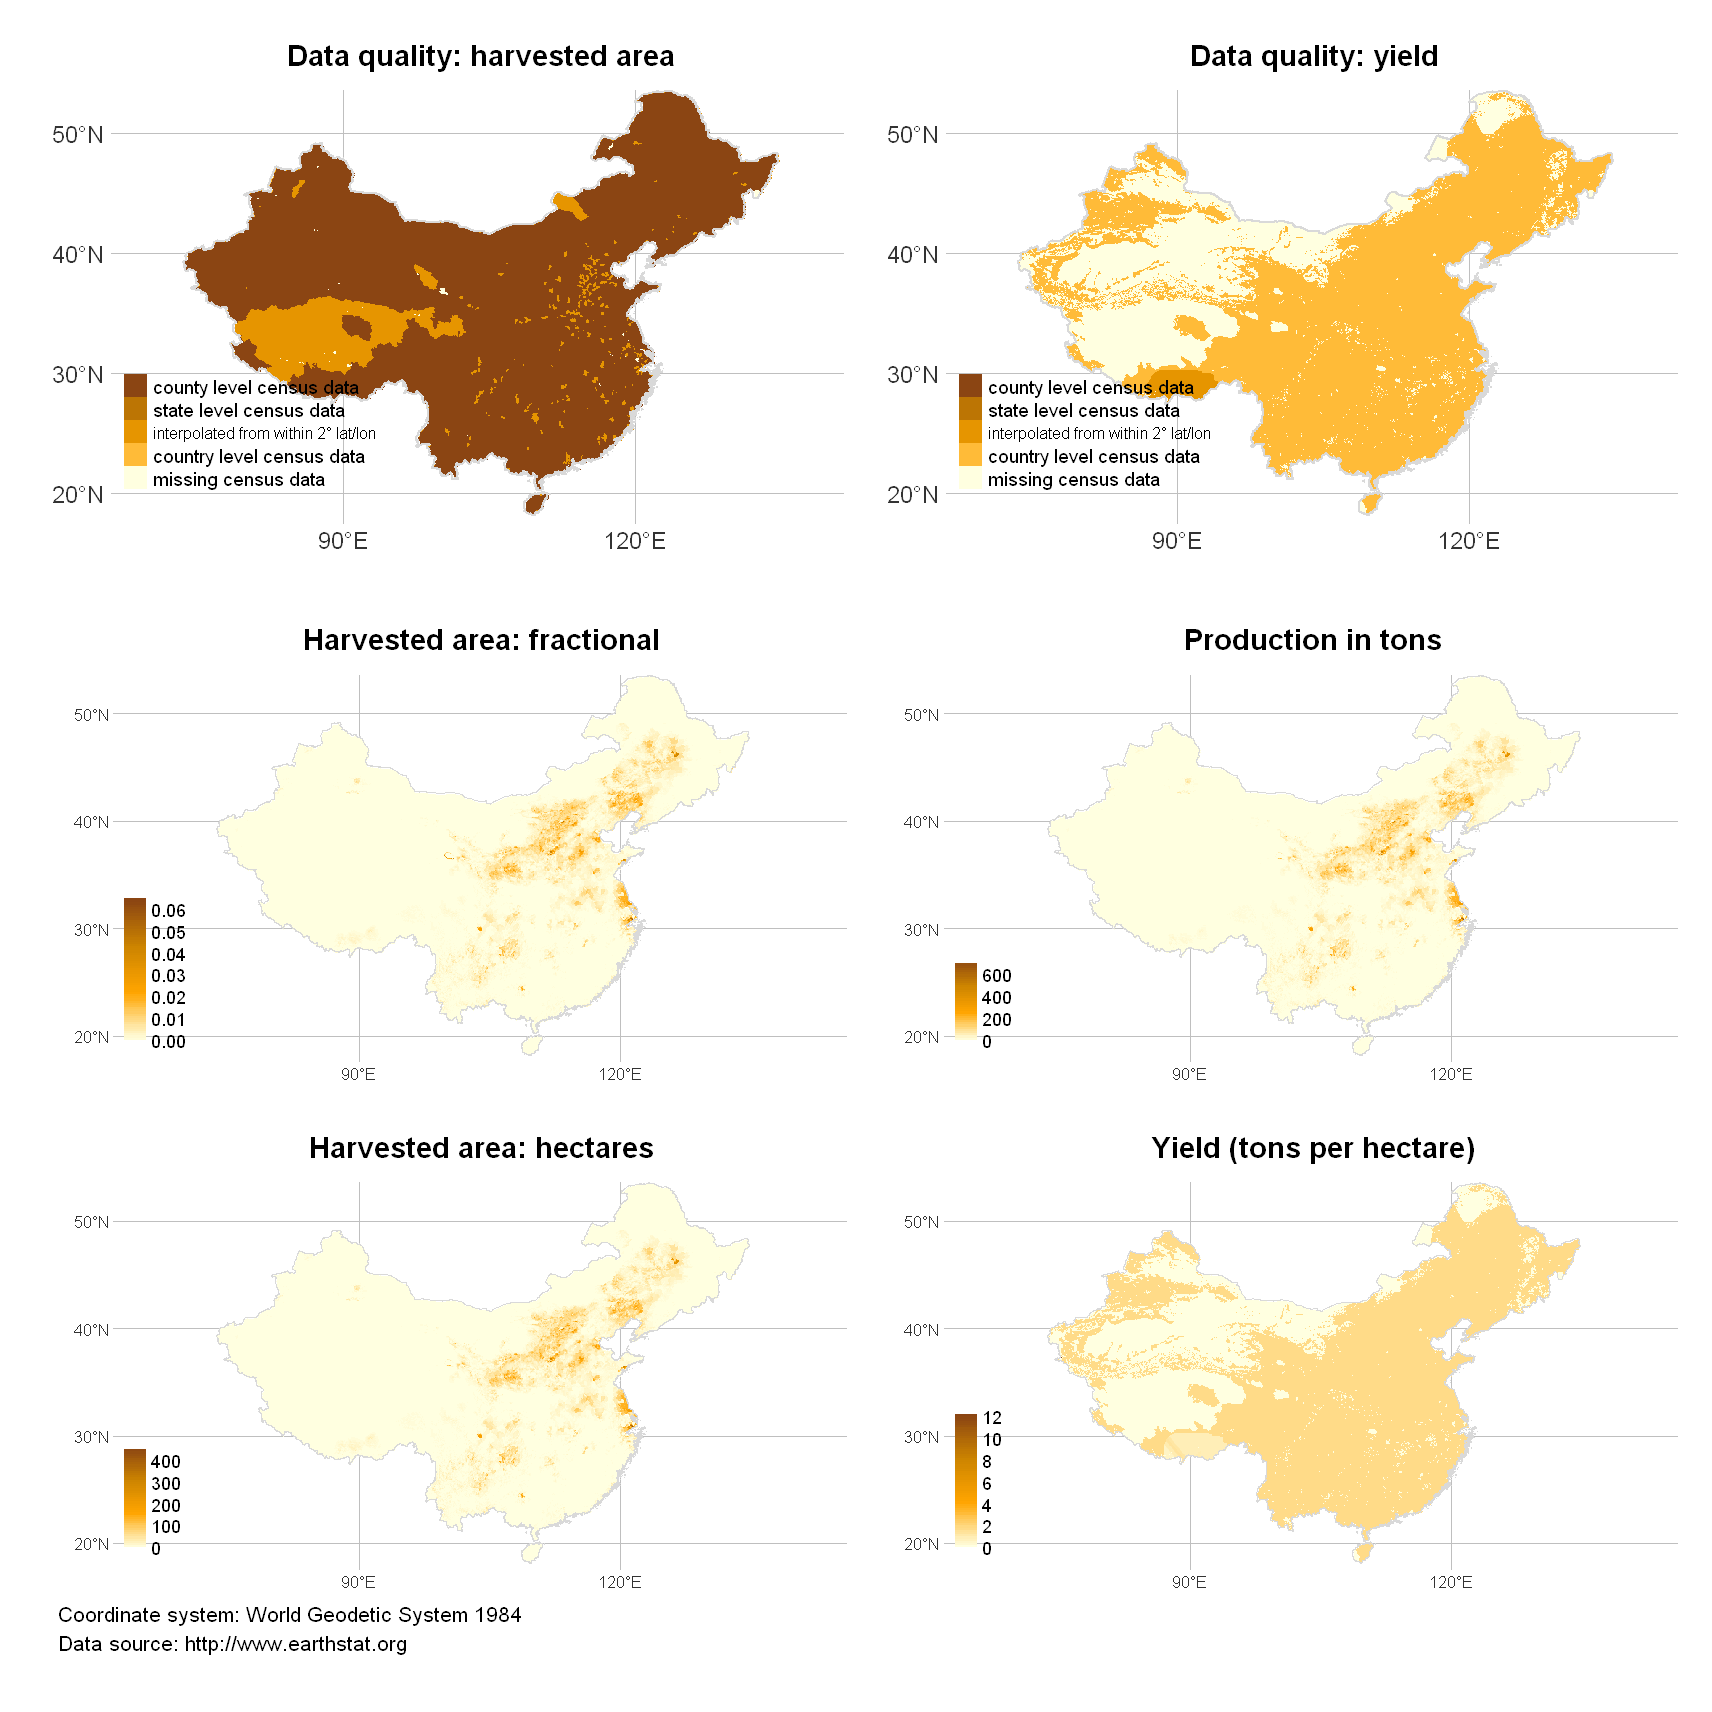

In [83]:
options(repr.plot.width=6.85,repr.plot.height=6.85,repr.plot.res=250)

## Plot production just for China

# Make panels for the data quality:
cprod1<-tm_shape(masked_prd[[c(1,2)]]) + # Order the maps in a sensible way
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.55)+ # Add lat-long lines
    # Add raster layer:
    tm_raster(labels=str_wrap(census_level,40),style="cat",palette=pal(4),legend.reverse = TRUE,title="",interval.closure="left",showNA=FALSE,colorNA="NA",midpoint=NULL)+
    # Make facets
    tm_facets(free.scales=FALSE,free.coords=TRUE,ncol=2,nrow=1,free.scales.raster=FALSE)+
    # Add continents outline
    tm_shape(china)+
    tm_borders(col="grey85")+
    theme_tmaps+
    tm_layout(panel.labels=prod_names[1:2],
              legend.position=c(0,0.05),
              legend.outside=FALSE,
              attr.outside=TRUE,
              panel.label.height=2,
              panel.label.size=0.7,
              legend.text.size=0.45
             )

# Make panels for the production data:
cprod2<-tm_shape(masked_prd[[c(3,5,4,6)]]) + # Order the maps in a sensible way
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.55)+ # Add lat-long lines
    # Add raster layer:
    tm_raster(style=c("cont","cont","cont","cont"),palette=pal(4),legend.reverse = TRUE,title="",interval.closure="left",showNA=FALSE,colorNA="NA",midpoint=NULL)+
    # Make facets
    tm_facets(free.scales=TRUE,free.coords=TRUE,ncol=2,nrow=2,free.scales.raster=TRUE)+
    # Add continents outline
    tm_shape(china)+
    tm_borders(col="grey85")+
    theme_tmaps+
    tm_layout(panel.labels=prod_names[c(3,5,4,6)],
              legend.position=c(0,0),
              attr.outside=TRUE,
              panel.label.height=2,
              panel.label.size=1,
              legend.text.size=0.6,
             )+
# Add info about the map projection
tm_credits("Coordinate system: World Geodetic System 1984\nData source: http://www.earthstat.org",position=c("left","bottom"),)

# Arrenge the maps together
cprod<-tmap_arrange(cprod1, cprod2, heights=c(1/3,2/3))

# Optional: show maps in jupyter:
cprod

In [ ]:
width=17.4
height=17.4
tmap_save(tm = cprod, filename = path2china_production, width = width, height = height,units = "cm",dpi = 600)

## Climate data

Data on the climatic conditions for the past 120 000 years is available from [figshare repository](https://figshare.com/articles/dataset/LateQuaternary_Environment_nc/12293345), published alongside [Beyer et al. 2019](https://doi.org/10.1038/S41597-020-0552-1) and will be used to define predictor variables in the model. The following code downloads the data, extracts them from the archive, extract relavant layers from the NetCDF file, masks them to the extent of China and saves them as tiff files for easier access in the analysis. It also makes a [table](../outputs/01_01_Predictor_variables.csv) with shortcuts and full names of environmental variables, that will be used for reference on the visualisations.

In [35]:
### Preparing environmental data for 6 time slices from Mid-Holocene to the present:

# Download the zipped folder
download.file(env_url,paste(env_fname,".zip",sep=""), mode = "wb")

# Unzip the folder and get the names of its contents:
files <- unzip(paste(env_fname,".zip",sep=""), exdir=env_fname)

# Removes the zipped folder:
file.remove(paste(env_fname,".zip",sep=""))

[1] TRUE

In [36]:
### Extract the relevant layers from NetCDF and saves them as raster:

# Open the NetCDF, in order to get the names of the variables that are stored there and summarizes the time dimension of the data
env_nc <- ncdf4::nc_open(files[1])
# Extracts the availabe variable names:
var_names <- names(env_nc$var)
#Included only those relevant for the analysis
short_names <-var_names[c(9,11:27)] 
# Define relevant time slices (past 8000 years + 15000 BP)
timeslices <-c(seq(1000,8000,by=1000),15000)
# Define the area to mask and crop the rasters by
area<-china


In [ ]:
# Extract the relevant layers from the NetCDF file, using the utility function provided in this repository
lapply(short_names,extractRastersFromNetCDF,path2file=files[1],timeslice=timeslices,area=area,path2layers=path2past_env,
       path2present=path2present_env,crop=TRUE,mask=TRUE )

In [76]:
### Additionally, prepare the table with the shortcuts of environmental variables and their full names
full_name <-c("Net Primary Production",'BIO1 Annual Mean Temperature',
              'BIO4 Temperature Seasonality', 
              'BIO5 Max Temperature of Warmest Month',
              'BIO6 Min Temperature of Coldest Month', 
              'BIO7 Temperature Annual Range', 
              'BIO8 Mean Temperature of Wettest Quarter',
              'BIO9 Mean Temperature of Driest Quarter',
              'BIO10 Mean Temperature of Warmest Quarter', 
              'BIO11 Mean Temperature of Coldest Quarter', 
              'BIO12 Annual Precipitation', 
              'BIO13 Precipitation of Wettest Month', 
              'BIO14 Precipitation of Driest Month',
              'BIO15 Precipitation Seasonality',
              'BIO16 Precipitation of Wettest Quarter',
              'BIO17 Precipitation of Driest Quarter', 
              'BIO18 Precipitation of Warmest Quarter',
              'BIO19 Precipitation of Coldest Quarter')
env_table <- cbind(short_names, full_name)

# Write the names of environmental variables to a csv file for future reference
write.csv(env_table, file=path2env_table,row.names=FALSE)

In [77]:
# Show table:

env_table

short_names,full_name
npp,Net Primary Production
BIO1,BIO1 Annual Mean Temperature
BIO4,BIO4 Temperature Seasonality
BIO5,BIO5 Max Temperature of Warmest Month
BIO6,BIO6 Min Temperature of Coldest Month
BIO7,BIO7 Temperature Annual Range
BIO8,BIO8 Mean Temperature of Wettest Quarter
BIO9,BIO9 Mean Temperature of Driest Quarter
BIO10,BIO10 Mean Temperature of Warmest Quarter
BIO11,BIO11 Mean Temperature of Coldest Quarter


## Fagopyrum pollen sites

This section extracts data about the pollen percentage at 6 additional sites from [Cao et al. 2013](https://doi.org/10.1016/j.revpalbo.2013.02.003) which have not been include in [Hunt et al. 2018](https://doi.org/10.1007/s00334-017-0649-4) and plots them to prepare [ESM 1](../outputs/ESM_1.pdf).

In [80]:
# Read data
pollen<-read.csv(path2pollen)

### Subset data for selected sites:
# Get all sites with Fagopyrum pollen from China
sites<-unique(subset(pollen,Fagopyrum>0&Country=="China")$Site)
# Manually exclude the sites already published by Hunt et al
sites<-sites[!(sites%in%c("Wangyanggou",'Changjiang River_1997'))]
# Subset the pollen data only for the selected sites
d<-subset(pollen, Site%in%sites)

In [84]:
# Prepare separate data frame for each site
data<-lapply(sites,function(x){
    d<-data.frame(d[d$Site==x,'Fagopyrum'],row.names=d[d$Site==x,'Cal.yr.BP'])
    colnames(d)<-"Fagopyrum"
    return(d)
})
names(data)<-sites

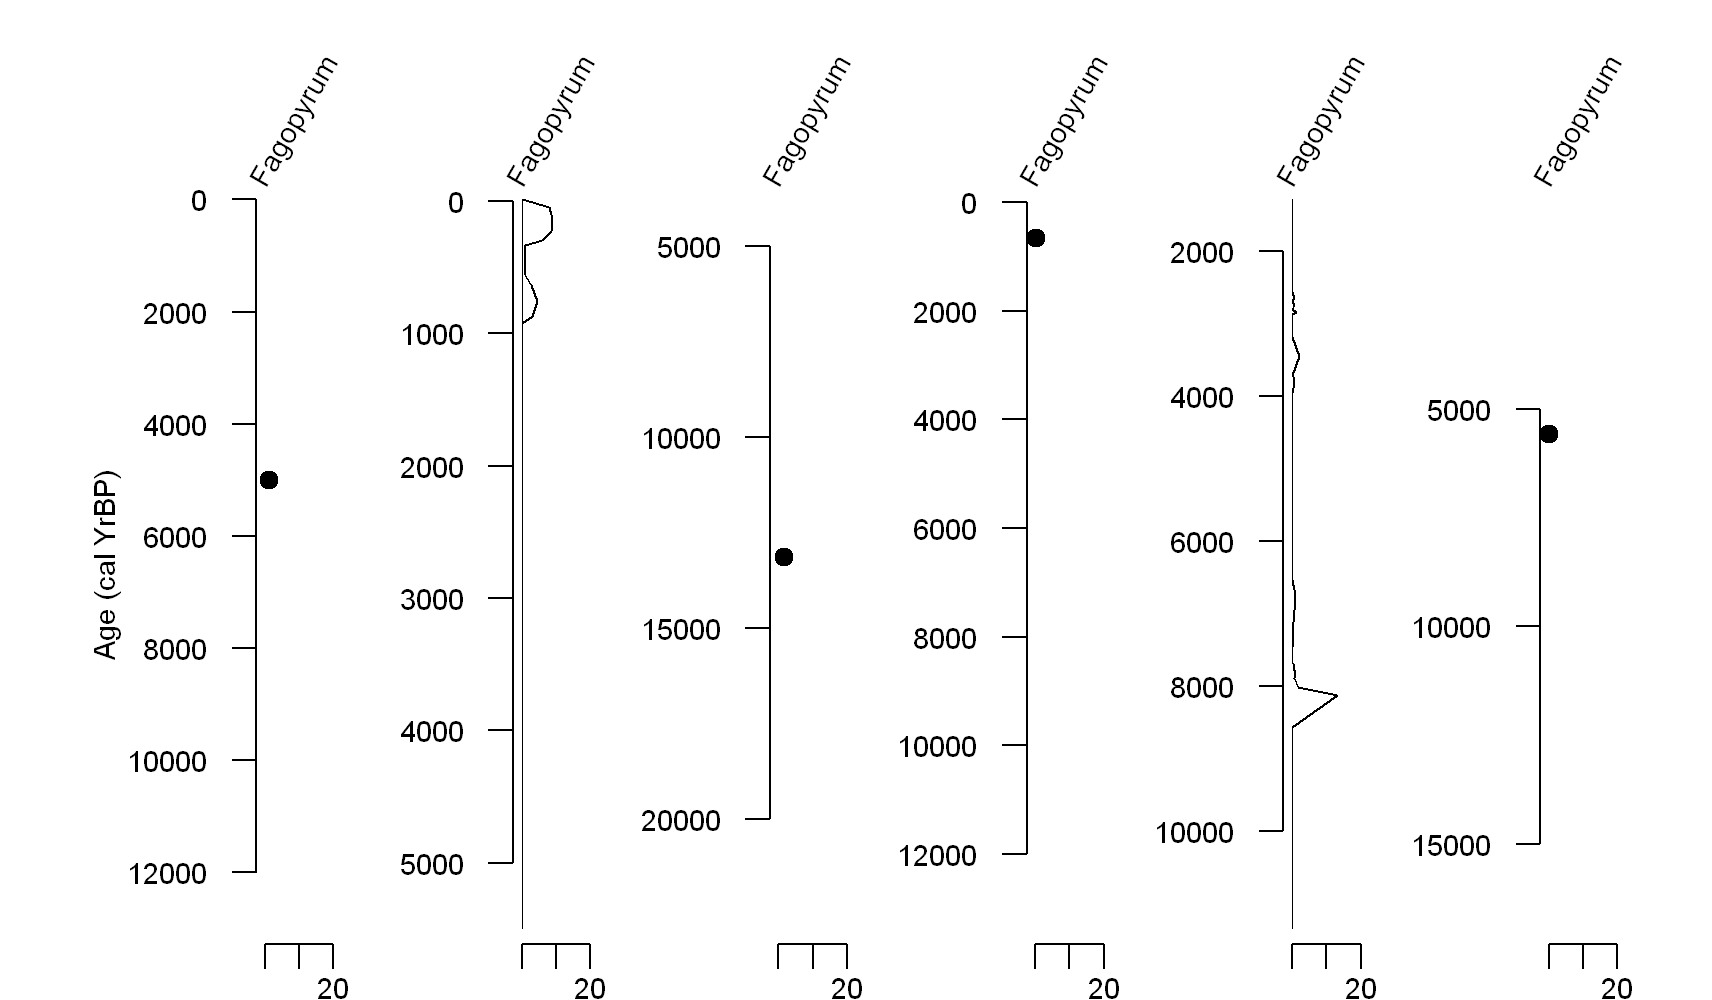

In [87]:
options(repr.plot.width=6.85,repr.plot.height=4,repr.plot.res=250)
# Plot diagrams for all sites
#pdf(path2pollen_diag,width = 6.85, height = 6.85) # Open pdf device - comment out to show in jupyter
par(mfrow=c(1,2)) #Plot all diagrams in one row
strat.plot(subset(data[[1]],Fagopyrum!=0),xLeft=-0.7,xRight=-0.6,title=str_wrap(names(data)[1],width=10),cex.title=0.7,x.names="Fagopyrum",srt.xlabel=60,ylabel="Age (cal YrBP)\n",cex.ylabel=0.7,yvar=rownames(subset(data[[1]],Fagopyrum!=0)),ylim=range(as.numeric(rownames(data[[1]]))),min.width=20,scale.percent=TRUE,plot.line=TRUE, plot.bar=FALSE,y.rev=TRUE,plot.symb=TRUE,cex.xlabel=0.7,cex.yaxis=0.7,cex.axis=0.7)
strat.plot(data[[2]],xLeft=-0.4,xRight=-0.3,title=names(data)[2],cex.title=0.7,x.names="Fagopyrum",srt.xlabel=60,ylabel="\n",cex.ylabel=0.7,yvar=rownames(data[[2]]),ylim=range(as.numeric(rownames(data[[2]]))),min.width=20,scale.percent=TRUE,plot.line=TRUE, plot.bar=FALSE,y.rev=TRUE,add=TRUE,cex.xlabel=0.7,cex.yaxis=0.7,cex.axis=0.7)
strat.plot(subset(data[[3]],Fagopyrum!=0),xLeft=-0.1,xRight=0,title=str_wrap(names(data)[3],width=10),cex.title=0.7,x.names="Fagopyrum",srt.xlabel=60,ylabel="\n",yvar=rownames(subset(data[[3]],Fagopyrum!=0)),ylim=range(as.numeric(rownames(data[[3]]))),min.width=20,scale.percent=TRUE,plot.line=TRUE, plot.bar=FALSE,y.rev=TRUE,add=TRUE,plot.symb=TRUE,cex.xlabel=0.7,cex.yaxis=0.7,cex.ylabel=0.7,cex.axis=0.7)
strat.plot(subset(data[[4]],Fagopyrum!=0),xLeft=0.2,xRight=0.3,title=str_wrap(names(data)[4],width=10),cex.title=0.7,x.names="Fagopyrum",srt.xlabel=60,ylabel="\n",yvar=rownames(subset(data[[4]],Fagopyrum!=0)),ylim=range(as.numeric(rownames(data[[4]]))),min.width=20,scale.percent=TRUE,plot.line=TRUE, plot.bar=FALSE,y.rev=TRUE,add=TRUE,plot.symb=TRUE,cex.xlabel=0.7,cex.yaxis=0.7,cex.ylabel=0.7,cex.axis=0.7)
strat.plot(data[[5]],xLeft=0.5,xRight=0.6,title=str_wrap(names(data)[5],width=10),cex.title=0.7,x.names="Fagopyrum",srt.xlabel=60,ylabel="\n",yvar=rownames(data[[5]]),ylim=range(as.numeric(rownames(data[[5]]))),min.width=20,scale.percent=TRUE,plot.line=TRUE, plot.bar=FALSE,y.rev=TRUE,add=TRUE,cex.xlabel=0.7,cex.yaxis=0.7,cex.ylabel=0.7,cex.axis=0.7)
strat.plot(subset(data[[6]],Fagopyrum!=0),xLeft=0.8,xRight=0.9,title=str_wrap(names(data)[6],width=10),cex.title=0.7,x.names="Fagopyrum",srt.xlabel=60,ylabel="\n",yvar=rownames(subset(data[[6]],Fagopyrum!=0)),ylim=range(as.numeric(rownames(data[[6]]))),min.width=20,scale.percent=TRUE,plot.line=TRUE, plot.bar=FALSE,y.rev=TRUE,add=TRUE,plot.symb=TRUE,cex.xlabel=0.7,cex.yaxis=0.7,cex.ylabel=0.7,cex.axis=0.7)
#dev.off() # Save in pdf - comment out if showing in jupyter

## Fagopyrum macro and microfossils locations

The dataset with the locations of fagopyrum macro and micro remains from the past was manually complied by form available sources and [is included in this repository](../data/ESM_2.csv). The code below downloads and subsets the shaded relief map from [NaturalEarth](https://www.naturalearthdata.com/) to be used as a background and plots the data to create [Figure 1](../outputs/Fig1.tiff) in the paper.

In [88]:
### Preparing environmental data for 6 time slices from Mid-Holocene to the present:

# Download the zipped folder
download.file(ne_url,paste(ne_fname,".zip",sep=""), mode = "wb")

# Unzip the folder and get the names of its contents:
files <- unzip(paste(ne_fname,".zip",sep=""), exdir=path2raw_data)

# Removes the zipped folder:
file.remove(paste(ne_fname,".zip",sep=""))

[1] TRUE

In [7]:
### Load shaded relief data:
map<-brick(paste(ne_fname,"///",sub('.*/', '',ne_fname),".tif",sep=""))
# Clip the map to the extent of China
clipped_rbg<-crop(map, extent(china), snap="out")
# Mask the map with the extent of China
cropped_rbg<-mask(clipped_rbg, china)

In [8]:
### Import Fagopyrum locations for China:

# Import the table for Fagopyrum occurance records, based on (Hunt et al., 2017) and further evidence from the literature
locations <- read.csv(path2locations)

# Transform data into a spatial points data.frame
coordinates(locations)<-~longitude+latitude

# Omit duplicate entry for Kyung-lung Mesa with no species identification
locations<-locations[!(locations$Site_short=="Kyung-lung Mesa"&locations$Taxonomic_identification=="Fagopyrum sp."),]

# Make separate subset for locations of Fagopyrum tataricum
loc_china<-locations[locations$Country=="China"&!(locations$Site_short%in%c("Qugong","Kyung-lung Mesa")),]
ft<-locations[locations$Country=="China"&locations$Taxonomic_identification%in%c("Fagopyrum tataricum"),]

In [9]:
### Load data with provinces of China to include as a backdrop
provinces <- readOGR(dsn = china_fname, layer = "CHN_adm1")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\BuckwheatNicheModelling\raw_data\CHN_adm", layer: "CHN_adm1"
with 31 features
It has 9 fields
Integer64 fields read as strings:  ID_0 ID_1 


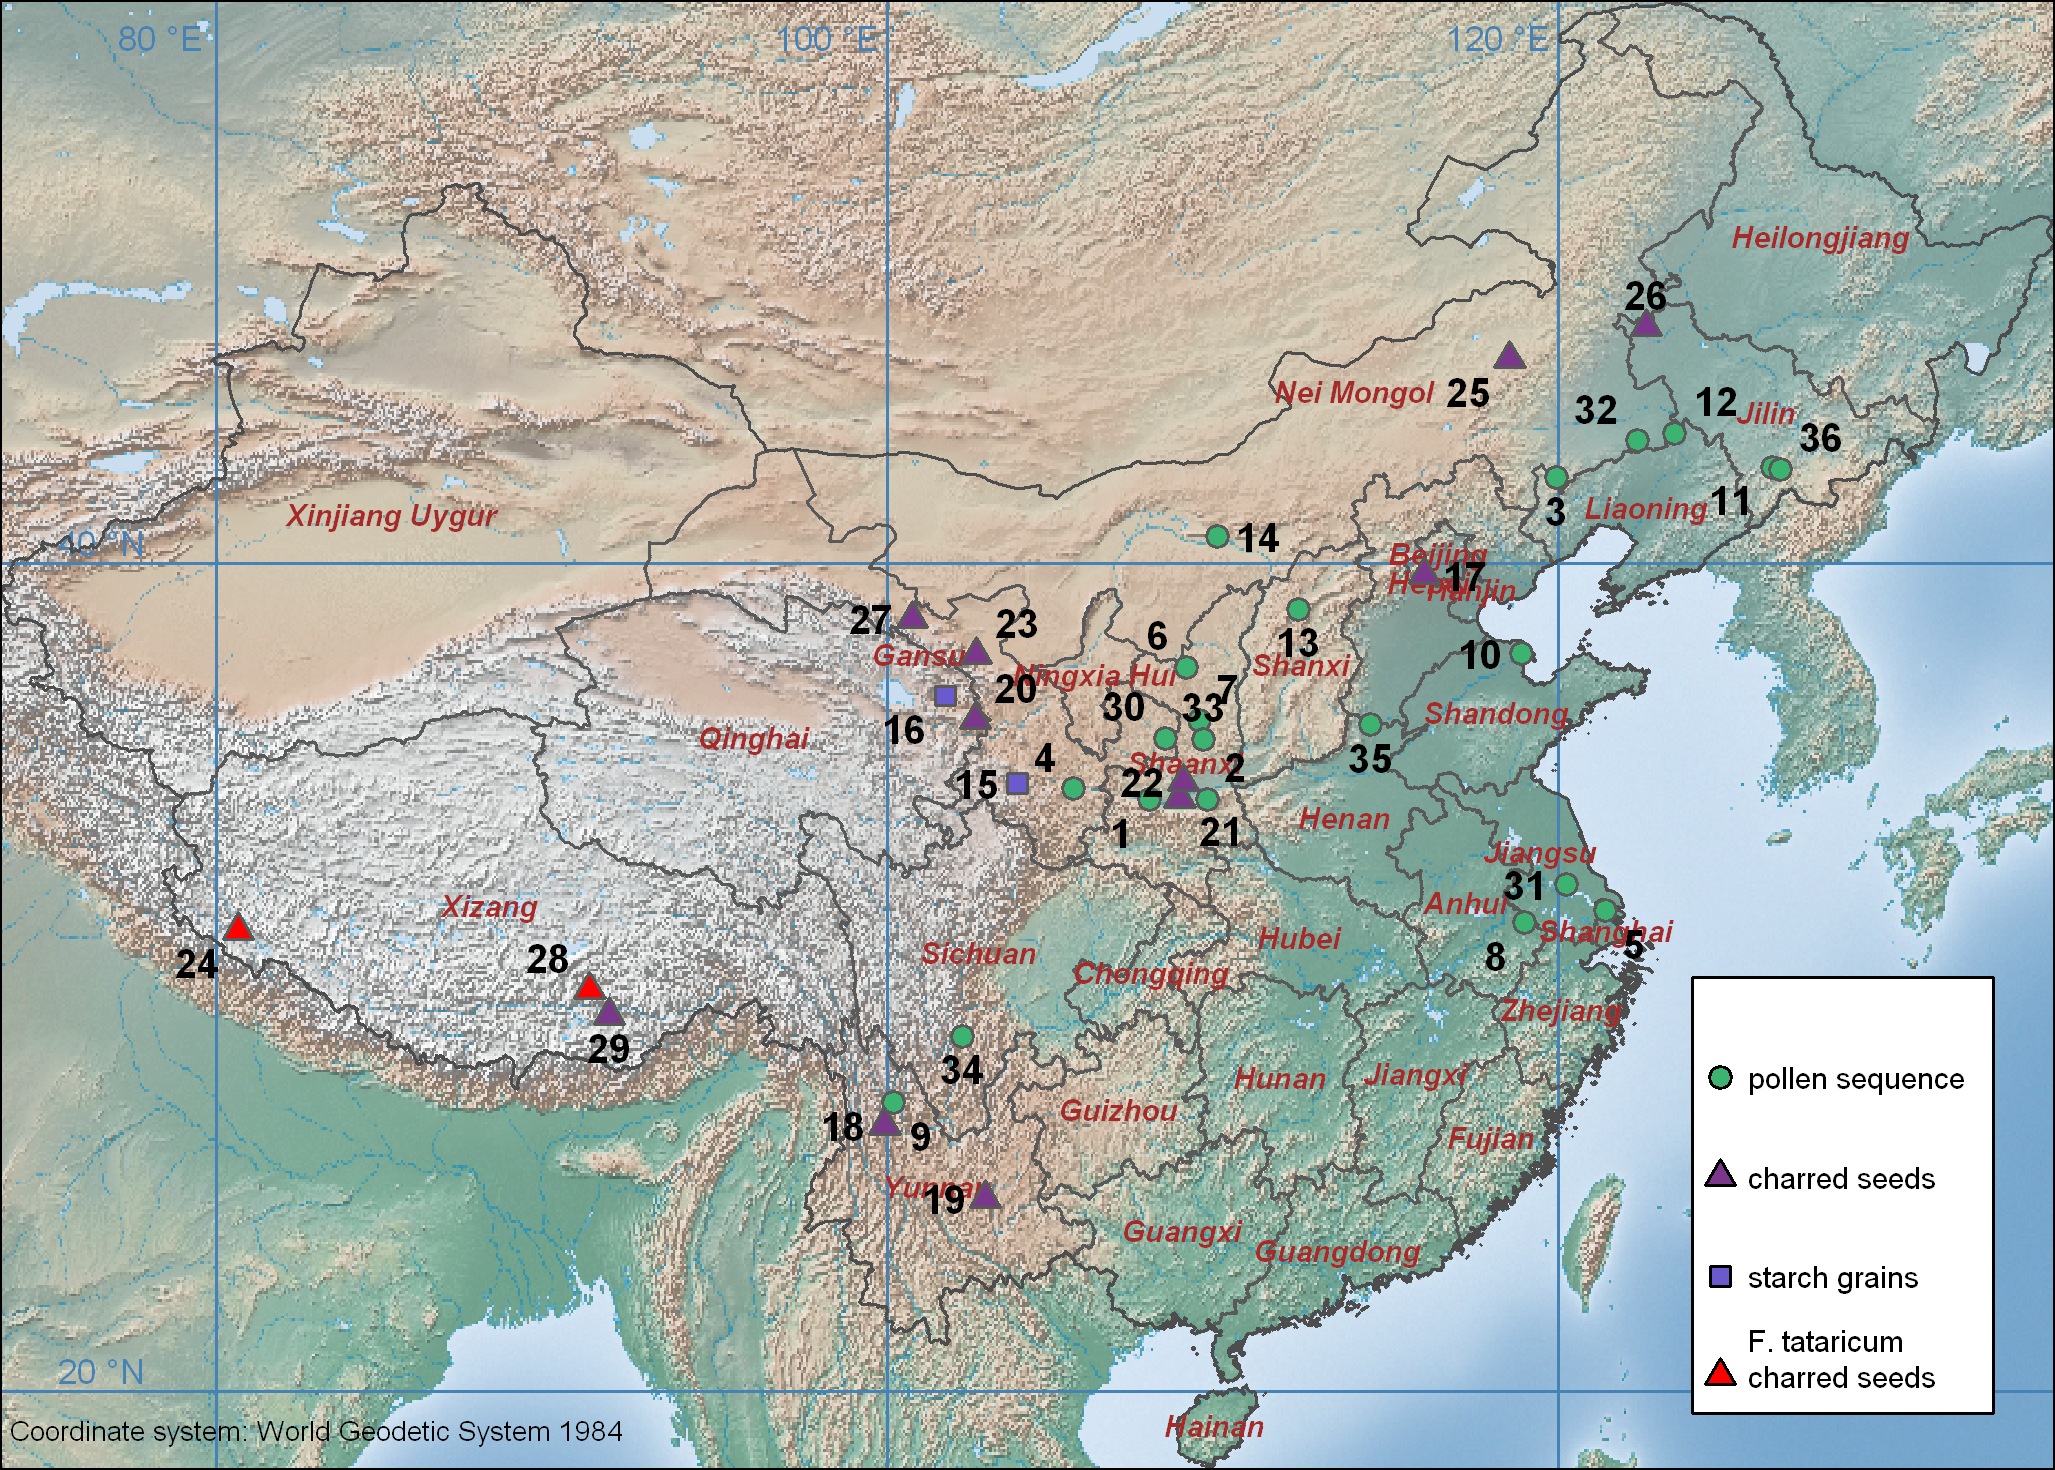

In [16]:
options(repr.plot.width=6.85,repr.plot.height=4.9,repr.plot.res=300)

### Plot the locations of Fagopyrum macro and micro-fossils over a relevent background
# Open the graphical device
#jpeg(path2locations_map,width=17.4, height=12.5,units="cm",res=600)

# Set margind
par(mar=c(0,0,0,0),oma=c(0,0,0,0),par(xpd=FALSE))
# Plot background
#plotRGB(clipped_rbg, margins=TRUE,axes=FALSE)
plotRGB(clipped_rbg, margins=FALSE,axes=FALSE)

# Add axes
axis(side=4, at=c(0,20,40,60),cex.axis=0.7,labels=c("0 °N\n","20 °N\n","40 °N\n","60 °N\n"),pos=c(73.5,120),tck=-2,las=2,cex=1.5,col="steelblue",col.axis="steelblue",xpd=FALSE)
axis(side=1, at=c(80,100,120),cex.axis=0.7,labels=c("80 °E           ","100 °E            ","120 °E            "),pos=55 ,tck=-1.5,cex=1.5,col="steelblue",lwd=1.2,col.axis="steelblue",xpd=FALSE)
# Add provinces and outline of China
plot(provinces, add=TRUE,border="grey35", axes=FALSE)
plot(china,add=TRUE,border="grey30",lwd=1.2,axes=FALSE)
text(provinces,provinces$NAME_1,cex=0.6,font=4,col="brown")
# Add location of sites by sample type
points(loc_china[loc_china$Sample_type=="Pollen sequence",],pch=21,bg="mediumseagreen",col="grey35")
points(loc_china[loc_china$Sample_type=="Charred seeds",],pch=24,bg="mediumorchid4",col="grey35")
points(loc_china[loc_china$Sample_type=="Starch grains",],pch=22,bg="slateblue",col="grey35")
points(ft,pch=24,bg="red",col="grey35")
# Add legend for site names
#legend("bottom", inset=c(0,-0.70), legend=paste(paste(as.character(1:nrow(locations[locations$Country=="China",])),".",sep=""),
#                                                locations[locations$Country=="China",]$Site_short,"\n    ",
#                                                locations[locations$Country=="China",]$Dating_result,"\n",sep=" "),
#       pch="",ncol=4,cex=0.7,text.width=13.3,bg="white")


# Add point labels
pointLabel(coordinates(locations[locations$Country=="China",]),method="SANN",labels=as.character(1:nrow(locations[locations$Country=="China",])),cex=0.8,col="black",font=2)
# Add legend for sample types
legend("bottomright",legend=c("pollen sequence", "charred seeds","starch grains","F. tataricum\ncharred seeds\n"),
       pt.bg=c("mediumseagreen", "mediumorchid4","slateblue","red"), pch=c(21,24,22,24),cex=0.6,pt.cex = 1,inset=c(0.03,0.17))
addnortharrow(pos = "topright") # Add north arrow
box()
text(83,19,"Coordinate system: World Geodetic System 1984",cex=0.55) # Add info about projection
# Close the device
#dev.off()

# For jupyter plot- set in legend:

#inset=.02

